# Introduction

**Upon completion of this lecture, we will**
- Understand what digital images are.
- Understand how images are acquired and formed.
- Understand the basics of image sampling and quantization.
- Know which tools to use when working with digital images in Python.
- Understand common gotchas of Numpy, Matplotlib and OpenCV.

**The lecture is based on**
- Chapter 1 of  
  [\[Burger22\] Wilhelm Burger, Mark J. Burge: "Digital Image Processing: An Algorithmic Introduction (3rd edition)"](https://imagingbook.com/books/english-edition-hardcover/)
- Chapter 2 of  
  [\[Gonzalez18\] Rafael C. Gonzalez, Richard E. Woods. "Digital Image Processing (4th edition)"](https://www.imageprocessingplace.com/)
- Chapter "Digital images" of  
  [\[Mazet24\] Vincent Mazet: "Basics of Image Processing"](https://vincmazet.github.io/bip/digital-images/intro.html)

# Basic terms

> **Signal processing** is an electrical engineering subfield that focuses on analyzing, modifying and synthesizing signals, such as sound, images, potential fields, seismic signals, altimetry processing, and scientific measurements.

&mdash; [Wikipedia](https://en.wikipedia.org/wiki/Signal_processing) 

> **Digital image processing** is the use of a digital computer to process digital images through an algorithm. It is a subcategory or field of digital signal processing.

&mdash; [Wikipedia](https://en.wikipedia.org/wiki/Digital_image_processing)

> **Image analysis** or imagery analysis is the extraction of meaningful information from images; mainly from digital images by means of digital image processing techniques.

&mdash; [Wikipedia](https://en.wikipedia.org/wiki/Image_analysis) 

> **Computer vision** tasks include methods for acquiring, processing, analyzing and understanding digital images, and extraction of high-dimensional data from the real world in order to produce numerical or symbolic information, e.g. in the forms of decisions.

&mdash; *[Wikipedia](https://en.wikipedia.org/wiki/Computer_vision)*

# Image formation (acquisition)

> The study of image formation encompasses the radiometric and geometric processes by which 2D images of 3D objects are formed. In the case of digital images, the image formation process also includes analog to digital conversion and sampling.

&mdash; [Wikipedia](https://en.wikipedia.org/wiki/Image_formation)

There are three major components that determine the appearance of an image [\[Angelopoulou\]](https://www5.informatik.uni-erlangen.de/fileadmin/lectures/2013s/Lecture.2013s.CV/image_formation.pdf):
1. Geometry (of both scene and camera)
2. Optical properties (of materials in the scene and of the sensor)
3. Illumination

## Pinhole camera model

- Camera obscura
- Requires very small opening (pinhole) to produce a sharp image, which reduces the amount of light
- This must be compensated for by very long exposure times
- Not used in practice, but a useful model for understanding
- [A real world example](https://web.eecs.umich.edu/~justincj/slides/eecs442/WI2021/442_WI2021_cameras.pdf)

<figure class="image">
  <img src="../figures/introduction-pinhole_camera_model.png" alt="" style="width: 6.4in;"/>
  <figcaption>Source: [Burger22], Fig. 1.2</figcaption>
</figure>

Pinhole camera model results in a **perspective projection**
$$
x = -f \cdot \frac{X}{Z} \qquad \textrm{and} \qquad y = -f \cdot \frac{Y}{Z}
$$
where
- $X, Y, Z$ are the scene coordinates (e.g. in meters)
- $f$ is the focal length (typically in millimeters)
- $x, y$ are image plane coordinates (e.g. in millimeters)

In perspective projection
- lines in 3D are projected to lines in 2D
- circles in 3D are projected to ellipses in 2D
- [cross ratio](https://en.wikipedia.org/wiki/Cross-ratio) is preserved

## Thin lens model

- A simplified model of real (thick) lenses
- A lens is considered to be thin if its thickness is much less than the radii of curvature
- The model ignores optical effects due to thickness, e.g. spherical distortion, chromatic abberation, astigmatism, etc.

<figure class="image">
  <img src="../figures/introduction-cnx_uphysics_35_04_thinlens.png" alt="" style="width: 6.4in;"/>
  <figcaption>
    Source: <a href="https://openstax.org/books/university-physics-volume-3/pages/2-4-thin-lenses">OpenStax: University Physics Volume 3</a>
  </figcaption>
</figure>

Thin lens camera model **results in the same geometry as the pinhole camera model**, i.e. the perspective projection as above

## Image sensing

- Conversion of the light energy into voltage or current
- The output is proportional to the incoming energy that has been collected over some period (exposure time)
- The output voltage is amplified by some factor. This can be controlled by ISO setting of the camera.  
  The larger the amplification, the less time we need to collect the light.  
  However, too short exposure time will lead to low signal-to-noise ratio and noisy images.
- The most common basic sensor is a photodiode

<figure class="image">
  <img src="../figures/introduction-photo_sensor.png" alt="" style="width: 6.4in;"/>
  <figcaption>Source: [Gonzalez18], Fig. 2.12</figcaption>
</figure>

**Camera sensors: CCD vs CMOS**
- Light sensors are usually organized into a line or rectangular grid-like pattern.
- There are two main technogies: **CCD and CMOS**.
1. **Charge coupled device (CCD)**
   - In CCD sensors, the charge generated by photons striking each sensor is transferred through the array of pixels in a serial manner.
   - There is only one shared output node that converts the accumulated charge into voltage.
   - Single conversion means that every pixel is amplified equally, which results in uniform gain & brightness, especially in low-light conditions.
   - Typically higher power consumption and slower speed as compared to CMOS.
   - Usually used in high quality cameras.
2. **Complementary metal–oxide–semiconductor (CMOS)**
   - Parallel readout architecture, where each pixel in the array has its own amplifier and readout, resulting in higher speed, but also non-uniform gain.
   - CMOS sensors typically have lower power consumption compared to CCD sensors, as they only activate the necessary circuitry when needed.
   - CMOS sensors can be manufactured using standard CMOS semiconductor fabrication processes, making them more cost-effective to produce in large volumes.
   - Mostly used in consumer grade devices (e.g. phones).

<figure class="image">
  <img src="../figures/introduction-ccd_vs_cmos.png" alt="" style="width: 6.4in;"/>
  <figcaption>Source: <a href="https://www.gatan.com/ccd-vs-cmos">gatan.com</a></figcaption>
</figure>

## Illumination-reflectance model

- We'll treat the image projected onto the image plane as a two-dimensional function $g(y,x): \mathbb{R}^2 \rightarrow \mathbb{R}$, i.e.
  - input is the position $(y,x)$ in the image plane 
  - output is the measured light energy at that position (a scalar whose units are not important)
- Hence, $g(y,x)$ is non-negative, i.e.
  $$
  0 \le g(y,x) \lt \infty
  $$
- Function $g(y, x)$ is characterized by two components:
  1. the amount of source **illumination** $l(y,x)$ incident on the scene being viewed, and
  2. the amount of illumination **reflected** $r(y,x)$ by the objects in the scene.

The illumination-reflectance model assumes a multiplicative effect, i.e.
 $$
 g(y,x) = l(y,x) \cdot r(y,x)
 $$
 where
 - illumination is $0 \le l(y,x) \lt \infty$,
 - reflectance is $0 \le r(y,x) \lt 1$, with $0$ meaning total absorption and $1$ meaning total reflectance.

## Sampling and quantization

In order to convert the observed continous image function $g(y,x)$ into a digital image $f(m,n)$, the folllowing two principal steps must be performed:

**1. Spatial sampling**
- Refers to the spatial arrangement of the sensor elements.
- Each sensor "samples" the light energy at its corresponding location in the image plane. For simplicity, we're going to assume pixels arrangement into a two-dimensional rectangular grid and neglect the pixel area and write
  $$
  h(m,n) = g(m \cdot \Delta y, n \cdot \Delta x)
  $$
  where
  - $\Delta x, \Delta y$ are distances between centers of the single-pixel sensors (sampling intervals),
  - $(m,n) \in \mathbb{N}^2$ are *discrete* pixel coordinates
  - $h(m,n) \in \mathbb{R}^+$
- For simplicity, we may neglect the pixel area and simply write
  
- Most often, the sensors are arranged into a regular rectangular grid-like pattern (matrix).  
  Other arrangements such as hexagonal grid are possible, but only used in specialized hardware.
- The total **image size** (pixel count) is usually expressed as $N \times M$ (width x height), e.g. $3840 \times 2160$.  
  **Beware the order**, as when the digital image is in matrix form, the convention is height x width, i.e. $M \times N$, i.e. $2160 \times 3840$.
- We may also need to know **spatial resolution** of the image, which may be expressed as
  - line pairs per unit distance (lp/mm)
  - dots (pixels) per unit distance, e.g. dots/pixels per inch (DPI/PPI)
  - This tells us how fine the sensor grid is and what is the size of each pixel in real-world units.

<figure class="image">
  <img src="../figures/introduction-mazet_moire.jpg" alt="" style="width: 6.4in; background-color: white;"/>
  <figcaption>Source: <a href="https://vincmazet.github.io/bip/digital-images/acquisition.html">Mazet24</a></figcaption>
</figure>

**2. Quantization of pixel values**
- The output of $f$ is a real number with an infinite amount of possible distinct values.
- It is not plausible to store values with infinite precision in computer memory.
- Usually, the range of possible output values of $h$ (codomain of $h$) is uniformly discretized into a $p$-bit integer scale, in which
  - 0 represents the lowest possible intensity (e.g. black)
  - $2^p-1$ represents the highest possible intensity (e.g. white).
- This process is called **quantization**.
- Formally, if we assume that
  $$
  h_{\textrm{min}} \le h(m,n) \le h_{\textrm{max}}
  $$
  then
  $$
  f(m,n) = \textrm{round}\left( \frac{2^p - 1}{h_{\textrm{max}} - h_{\textrm{min}}} \cdot (h(m,n) - h_{\textrm{min}}) \right)
  $$

$p$ | Range        | Use
----|--------------|----------------------------------------------
1   | $\{0, 1\}$   | Binary images: document, illustration, fax
8   | $[0, 255]$   | Universal and most common: photo, scan, print
10  | $[0, 1023]$  | HDR videos for modern displays
12  | $[0, 4095]$  | Medicine, satellite imaging, astronomy
16  | $[0, 65535]$ | Medicine, satellite imaging, astronomy

<figure class="image">
  <img src="../figures/introduction-mazet_quantization.png" alt="" style="width: 6.4in; background-color: white;"/>
  <figcaption>Source: <a href="https://vincmazet.github.io/bip/digital-images/acquisition.html">Mazet24</a></figcaption>
</figure>

<figure class="image">
  <img src="../figures/introduction-sampling_and_quantization.png" alt="" style="width: 6.4in;"/>
  <figcaption>Source: [Gonzalez18], Fig. 2.16</figcaption>
</figure>

# Digital images

- For example, the result of the image acquistion above could be an integer digital image $f(m,n) \in \{0, \ldots, 2^p-1\}$.
- We may view such image as a two-dimensional discrete function, which gives us a value $f(m,n)$ for each pixel position $(m,n)$.
- The position $(m,n)$ is a pair from a set of possible locations $\{0, \ldots, M-1\} \times \{0, \ldots, N-1\}$.
- $m$ denotes row, $n$ denotes column, e.g. $f(0,1)$ means value at 1st row and 2nd column.
- The origin $(0, 0)$ is top-left.

<figure class="image">
  <img src="../figures/introduction-image_coords.png" alt="" style="width: 6.4in;"/>
  <figcaption>Source: [Burger22], Fig. 1.6</figcaption>
</figure>

**RGB images**

- If the image has color, there will be **three values** for each pixel location $(m,n)$, i.e.
  $$
  f(m,n) \in \{0, \ldots, 2^p-1\} \times \{0, \ldots, 2^p-1\} \times \{0, \ldots, 2^p-1\}
  $$
- In other words, value of $f$ at each position would be a triple, i.e.
  $$
  f(m,n) = (R, G, B)
  $$
  with $R \in \{0, \ldots, 2^p-1\}$, $B \in \{0, \ldots, 2^p-1\}$, and $C \in \{0, \ldots, 2^p-1\}$

**Float images**
- Sometimes, we also work with images whose values are real numbers, often in the range $[0, 1]$.  
  Even though the values are real numbers, they are still limited by the numerical precision of the data type they are stored in the computer memory. This means that the set of possible distinct values is still finite.

**Digital image as a discrete function**

In general, the acquired *digital image* is a discrete function
$$
f: \mathbb{N}^D \rightarrow \mathbb{R}^C$$
that maps $D$ discrete coordinates
$$(m,n,\ldots) \in \{0, \ldots, M-1\} \times \{0, \ldots, N-1\} \times \ldots
$$
to a tuple of $C$ values from a finite set of intensities $(l_1, \ldots, l_C) \in \mathbb{R}^C$
$$
f(m,n,\ldots) \in \mathbb{R}^C
$$

In other words image can be seen as an array of $D$ dimensions and size $M \times N \times \ldots$ whose elements contain $C$ numbers
[\[Mazet24\]](https://vincmazet.github.io/bip/digital-images/definition.html). We may consider the number $C$ as the number of image channels.

For example
- An 8-bit integer grayscale image with values between 0 (black) and 255 (white) and size $640 \times 480$ would correspond to
  - $D = 2$, since it is a *two*-dimensional image, i.e. each position is a pair $(m,n)$,
  - $M = 480$, $N = 640$, since $M$ is the number of rows and $N$ is the number of columns,
  - pixel coordinates would be any combination of $m = 0, \ldots, 479$ and $n = 0, \ldots, 639$,
  - $f(m,n) \in \{0, \ldots, 255\}$, since it is an 8-bit image,
  - $C = 1$, since it only has a single intensity channel (no color), i.e. the value of $f(m,n)$ is a scalar.
- RGB color version of the same image would correspond to
  - $C = 3$, since there would be three channels R, G and B.
- An MRI or CT image would correspond to
  - $D = 3$, since it would be a volume,
  - $C = 1$, since there is only a single value for each voxel.
- A video could correspond to
  - $D = 3$, since there would also be time component,
  - $C = 3$, if it has color.

**Digital image as a matrix**

In practice, when working with images in Python libraries such as scikit-image or OpenCV, digital images will be stored and represented as a simple two-dimensional array, a.k.a a matrix
$$
\bold{F} = \begin{bmatrix}
    f_{1,1} & \ldots & f_{1,N} \\
    \vdots  & \ddots & \vdots  \\
    f_{M,1} & \ldots & f_{M,N}
\end{bmatrix}
$$
where
- $f_{m,n} = f(m,n)$

# Image arithmetics

**Image addition**

$$
f(m,n) = f_1(m,n) + f_2(m,n)
$$

- Example: blend two images

<figure class="image">
  <img src="../figures/introduction-image_addition.svg" alt="" style="width: 6.4in; background-color: white;"/>
  <figcaption>Source: <a href="https://vincmazet.github.io/bip/digital-images/operations.html">Mazet24</a></figcaption>
</figure>


**Image subtraction**

$$
f(m,n) = f_1(m,n) - f_2(m,n)
$$

- Example: detect changes between two images

<figure class="image">
  <img src="../figures/introduction-image_subtraction.svg" alt="" style="width: 6.4in; background-color: white;"/>
  <figcaption>Source: <a href="https://vincmazet.github.io/bip/digital-images/operations.html">Mazet24</a></figcaption>
</figure>


**Image division**

$$
f(m,n) = \frac{f_1(m,n)}{f_2(m,n)}
$$

- Example: correct non-homogeneous illumination

<figure class="image">
  <img src="../figures/introduction-image_division.svg" alt="" style="width: 6.4in; background-color: white;"/>
  <figcaption>Source: <a href="https://vincmazet.github.io/bip/digital-images/operations.html">Mazet24</a></figcaption>
</figure>

# Popular image file formats

<figure class="image">
  <img src="../figures/introduction-raster_vs_svg.png" alt="" style="width: 6.4in; background-color: white;"/>
  <figcaption>Source: <a href="https://en.wikipedia.org/wiki/SVG">Wikipedia</a></figcaption>
</figure>

**Bitmap (BMP)**
- Raster graphics file
- Supports grayscale, indexed and true color images
- Basic Run Length Encoding (RLE) compression

**Graphics Interchange Format (GIF)**
- Raster graphics file
- Supports indexed color at multiple depths, interlaced image loading
- Lossless Lempel-Ziv-Welsch (LZW) compression
- Can store multiple images in a single file and animate
- Popular on the web

**Portable Network Graphics (PNG)**
- Raster graphics file
- Supports up to $3 \times 16$ bit per pixel, indexed color images, alpha channel
- Up to $2^{30} \times 2^{30}$ pixels
- Lossless Phil Katz's ZIP (PKZIP) compression
- Should be the default choice for lossless images

**Tagged Image File Format (TIFF)**
- Raster graphics file
- Flexible file format designed to meet the professional needs of diverse fields
- Supports large integer depth and floating point pixels
- Supports both lossless (LZW, ZIP, CCIT) and lossy compression (JPEG)
- Multiple images in single file (pages)
- Supports arbitrary metadata

**JPEG File Interchange Format (JFIF)**
- Joint Photography Experts Group (JPEG)
- Raster graphics file
- Lossy compression based on Discrete Cosine Transform (DCT), Huffman coding and RLE
- Compression about 1 bit per pixel

**Scalable Vector Graphics (SVG)**
- Vector graphics file
- Represented as XML that defines 14 (SVG 1.1) functional areas and feature sets (e.g. paths, shapes, text, etc.)
- Supports interactivity, animation, and rich graphical capabilities, making it suitable for both web and print applications
- Can have raster image inside
- Lossless compression (GZIP)

# Tools and libraries for image processing in Python

## Sidenote: Markdown

<figure class="image">
  <img src="https://www.markdownguide.org/assets/images/markdown-mark-white.svg" alt="" style="width: 1.6in"/>
</figure>

https://www.markdownguide.org/


Regular text, then **bold text**, even math
$$\frac{a^2}{(\log \sqrt p)}$$
Code reference may look like `this_is_name_of_variable`
Code block:
``` python
class A:
    pass
```
``` javascript
let x = Math.Random()
```

## Numpy

<figure class="image">
  <img src="https://numpy.org/images/logo.svg" alt="" style="width: 1.6in"/>
</figure>

https://numpy.org/

In [1]:
import numpy as np

In [2]:
np.arange(12)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [3]:
x = np.arange(12).reshape(3, 4)
x

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [4]:
type(x), x.shape, x.dtype

(numpy.ndarray, (3, 4), dtype('int32'))

In [5]:
x.T

array([[ 0,  4,  8],
       [ 1,  5,  9],
       [ 2,  6, 10],
       [ 3,  7, 11]])

In [6]:
x[1, 2]

6

In [7]:
r = x[0, :]
r

array([0, 1, 2, 3])

In [8]:
type(r), r.shape

(numpy.ndarray, (4,))

In [9]:
type(r.shape)

tuple

In [10]:
l = [1, 2, 3]
l[0] = 4
l

[4, 2, 3]

In [11]:
t = (1, 2, 3)
t = (4, t[1], t[2])
t

(4, 2, 3)

### View vs copy

In [12]:
x

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [13]:
r

array([0, 1, 2, 3])

In [14]:
r[0] = -1
r

array([-1,  1,  2,  3])

In [15]:
x

array([[-1,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [16]:
r_copy = x[0, :].copy()
r_copy

array([-1,  1,  2,  3])

In [17]:
r_copy[0] = -2
r_copy

array([-2,  1,  2,  3])

In [18]:
x

array([[-1,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

### Indexing

In [19]:
x = np.arange(2 * 3 * 4).reshape(2, 3, 4)
x

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

In [20]:
x.shape

(2, 3, 4)

In [21]:
x[:, 2]

array([[ 8,  9, 10, 11],
       [20, 21, 22, 23]])

In [22]:
x[1]

array([[12, 13, 14, 15],
       [16, 17, 18, 19],
       [20, 21, 22, 23]])

In [23]:
x[:, :, 1::2]

array([[[ 1,  3],
        [ 5,  7],
        [ 9, 11]],

       [[13, 15],
        [17, 19],
        [21, 23]]])

In [24]:
x[:, :, [0, 1, -1]]

array([[[ 0,  1,  3],
        [ 4,  5,  7],
        [ 8,  9, 11]],

       [[12, 13, 15],
        [16, 17, 19],
        [20, 21, 23]]])

In [25]:
x[-2]

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [26]:
x[:, :, [0]]

array([[[ 0],
        [ 4],
        [ 8]],

       [[12],
        [16],
        [20]]])

### Broadcasting

In [27]:
x

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

In [28]:
x + 1

array([[[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12]],

       [[13, 14, 15, 16],
        [17, 18, 19, 20],
        [21, 22, 23, 24]]])

In [29]:
a = np.arange(5).reshape(5, 1)
a

array([[0],
       [1],
       [2],
       [3],
       [4]])

In [30]:
b = np.arange(3).reshape(1, 3)
b

array([[0, 1, 2]])

In [31]:
a + b

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6]])

In [32]:
x = np.random.rand(3, 5)
x

array([[0.91982401, 0.22380183, 0.77587504, 0.78599604, 0.71015576],
       [0.90297573, 0.07769691, 0.61708218, 0.54247363, 0.29438033],
       [0.6382408 , 0.0107412 , 0.54490834, 0.28966261, 0.0740847 ]])

In [33]:
x.sum()

7.407899092287884

In [34]:
x.sum(axis=0)

array([2.46104054, 0.31223994, 1.93786555, 1.61813228, 1.07862079])

In [35]:
x.sum(axis=1)

array([3.41565267, 2.43460877, 1.55763765])

In [36]:
x.sum(axis=1, keepdims=True)

array([[3.41565267],
       [2.43460877],
       [1.55763765]])

In [37]:
x_norm = x / x.sum(axis=1, keepdims=True)
x_norm

array([[0.2692967 , 0.06552242, 0.22715279, 0.23011592, 0.20791217],
       [0.37089151, 0.03191351, 0.25346256, 0.22281758, 0.12091484],
       [0.40974921, 0.00689582, 0.34982997, 0.18596277, 0.04756222]])

In [38]:
x_norm.sum(axis=1)

array([1., 1., 1.])

## Matplotlib

<figure class="image">
  <img src="https://matplotlib.org/_static/logo_dark.svg" alt="" style="width: 1.6in"/>
</figure>

https://matplotlib.org/

In [39]:
import matplotlib.pyplot as plt

In [40]:
t = np.linspace(0., 1., 100)
x = np.sin(2. * np.pi * t)

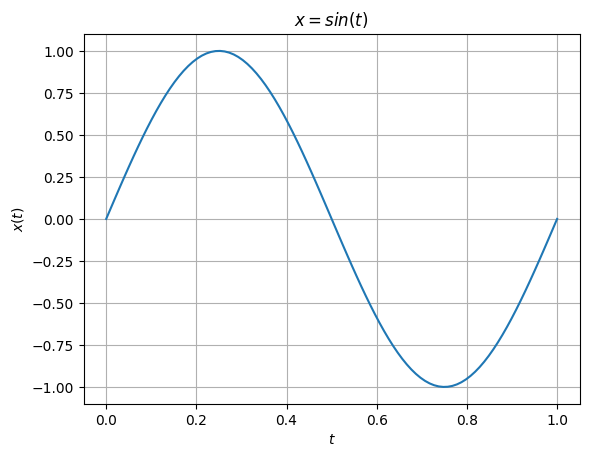

In [41]:
plt.plot(t, x);
plt.xlabel('$t$');
plt.ylabel('$x(t)$');
plt.title('$x = sin(t)$');
plt.grid();

In [42]:
xx = x.reshape(-1, 1) * x.reshape(1, -1)
xx.shape, xx.dtype, xx.min(), xx.max()

((100, 100), dtype('float64'), -0.9997482711915926, 0.9997482711915926)

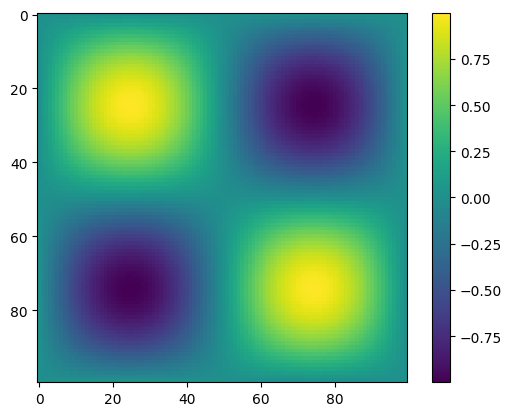

In [43]:
plt.imshow(xx);
plt.colorbar();

In [44]:
tx, ty = np.meshgrid(t, t)
print(tx.shape, tx.dtype, tx.min(), tx.max())
print(ty.shape, ty.dtype, ty.min(), ty.max())

(100, 100) float64 0.0 1.0
(100, 100) float64 0.0 1.0


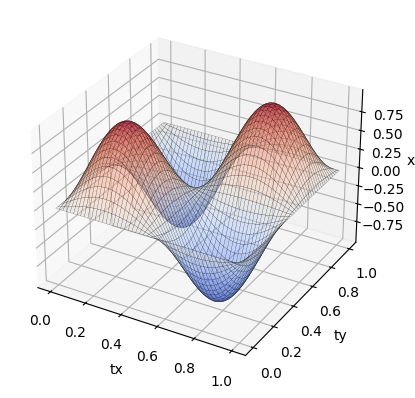

In [45]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(tx, ty, xx, cmap='coolwarm', ec='k', lw=0.1, alpha=0.5);
ax.set_xlabel('tx');
ax.set_ylabel('ty');
ax.set_zlabel('xx');
# ax.view_init(elev=30, azim=120, roll=0);

## Seaborn

<figure class="image">
  <img src="https://seaborn.pydata.org/_static/logo-wide-lightbg.svg" alt="" style="width: 1.6in"/>
</figure>

https://seaborn.pydata.org/

In [46]:
import seaborn as sns

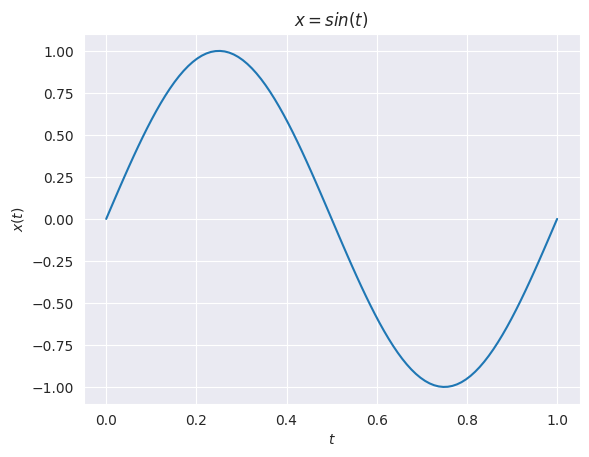

In [47]:
with sns.axes_style(style='darkgrid'):
    plt.plot(t, x);
    plt.xlabel('$t$');
    plt.ylabel('$x(t)$');
    plt.title('$x = sin(t)$');

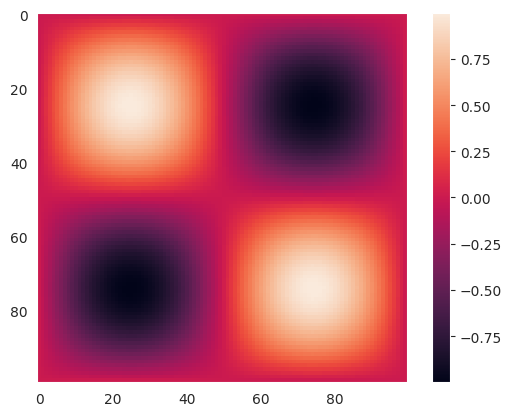

In [48]:
with sns.axes_style(style='dark'):
    plt.imshow(xx);
    plt.colorbar();

## Scikit-image

<figure class="image">
  <img src="https://scikit-image.org/_static/img/logo.png" alt="" style="width: 1.6in"/>
</figure>

https://scikit-image.org/

In [49]:
import skimage

In [50]:
rgb = skimage.io.imread('../data/fruits.jpg')
type(rgb), rgb.shape, rgb.dtype, rgb.min(), rgb.max()

(numpy.ndarray, (3396, 3396, 3), dtype('uint8'), 0, 255)

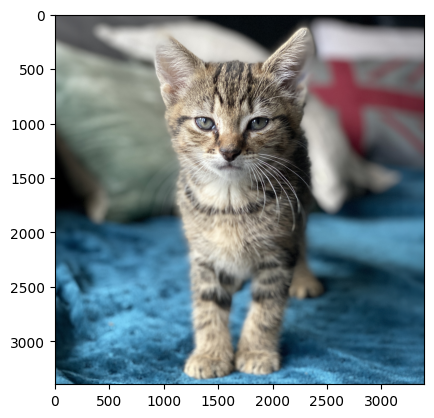

In [51]:
plt.imshow(rgb);

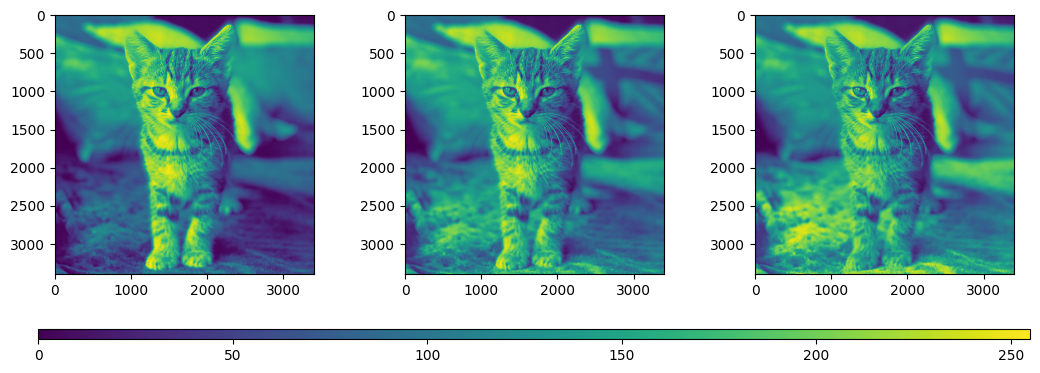

In [52]:
fig, axes = plt.subplots(1, 3, figsize=plt.figaspect(0.375))
im = axes[0].imshow(rgb[:, :, 0])  # R
im = axes[1].imshow(rgb[:, :, 1])  # G
im = axes[2].imshow(rgb[:, :, 2]);  # B
fig.colorbar(im, ax=axes, orientation='horizontal', aspect=100);

In [53]:
gray = skimage.color.rgb2gray(rgb)
gray.shape, gray.dtype, gray.min(), gray.max()

((3396, 3396), dtype('float64'), 0.0, 1.0)

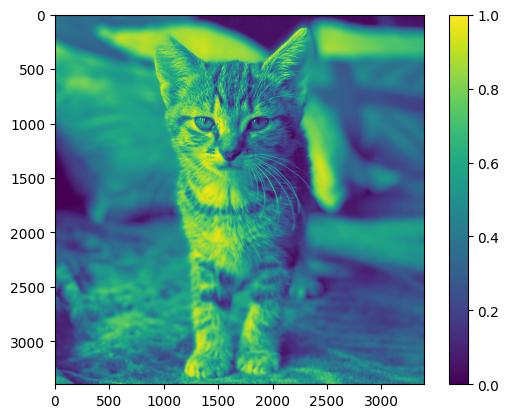

In [54]:
plt.imshow(gray)
plt.colorbar();

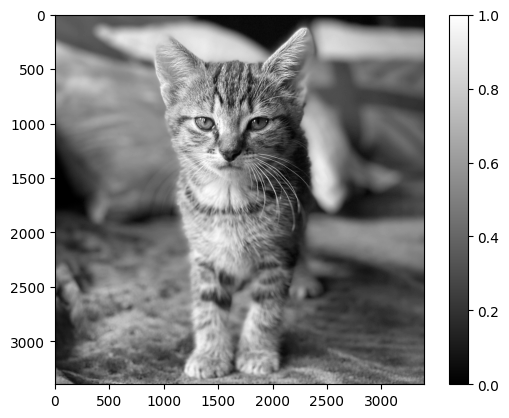

In [55]:
plt.imshow(gray, cmap='gray', vmin=0, vmax=1)
plt.colorbar();

## Convert to float

In [56]:
rgb / 255.

array([[[0.4       , 0.45490196, 0.45882353],
        [0.40392157, 0.44705882, 0.45490196],
        [0.38823529, 0.42352941, 0.44313725],
        ...,
        [0.14509804, 0.19607843, 0.22745098],
        [0.19215686, 0.25098039, 0.27843137],
        [0.18823529, 0.25490196, 0.28235294]],

       [[0.39215686, 0.44705882, 0.45098039],
        [0.39607843, 0.43921569, 0.44705882],
        [0.38823529, 0.41568627, 0.43921569],
        ...,
        [0.14117647, 0.19215686, 0.22352941],
        [0.18823529, 0.24705882, 0.2745098 ],
        [0.19215686, 0.25098039, 0.27843137]],

       [[0.38431373, 0.42745098, 0.43529412],
        [0.38431373, 0.42352941, 0.43137255],
        [0.37254902, 0.40392157, 0.41568627],
        ...,
        [0.12941176, 0.17254902, 0.19607843],
        [0.16078431, 0.21176471, 0.23529412],
        [0.15686275, 0.21568627, 0.23529412]],

       ...,

       [[0.4745098 , 0.55686275, 0.63137255],
        [0.4745098 , 0.55686275, 0.63921569],
        [0.47058824, 0

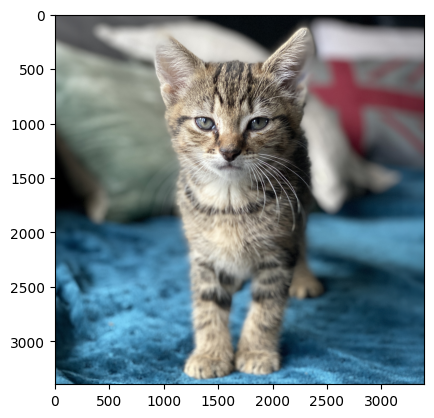

In [57]:
plt.imshow(rgb / 255.);

`plt.imshow` also examines the `dtype` of the argument and then decides:
- `uint8` dtype will be rendered with zeros meaning minimum and 255 meaning maximum value
- `float32` or `float` dtype will be rendered with zeros meaning minimum and 1 meaning maximum value

Any value of `float` dtype larger than one will be rendered as white too, so if we don't divide by 255, we'll get an almost white output:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


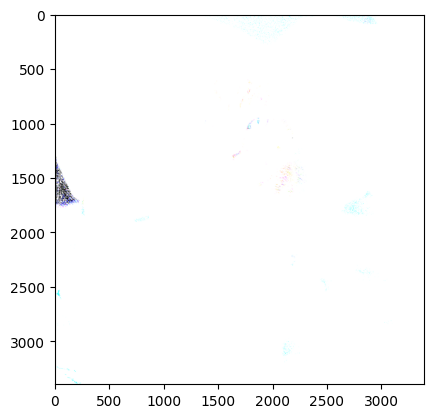

In [58]:
plt.imshow(rgb.astype(float));

The proper way to convert data type of images in scikit-image is to use `skimage.utils.img_as_xxx` like so:

In [59]:
rgb_f = skimage.util.img_as_float(rgb)  # convert to float dtype (0..1)
rgb_b = skimage.util.img_as_ubyte(rgb_f)  # convert back to unsigned byte (0..255)

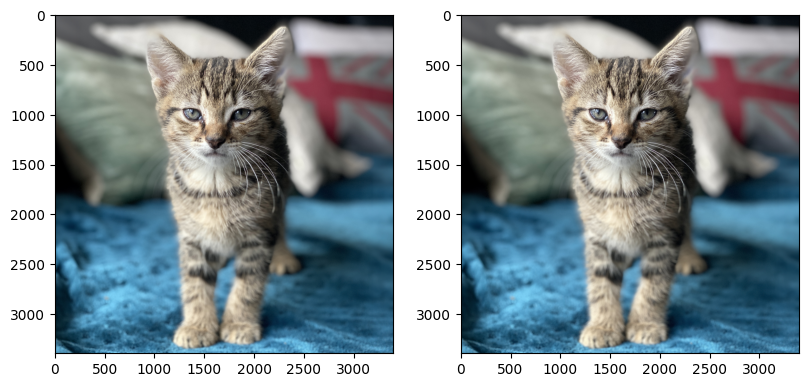

In [60]:
fig, axes = plt.subplots(1, 2, figsize=plt.figaspect(0.5))
axes[0].imshow(rgb_f)
axes[1].imshow(rgb_b);

## OpenCV

<figure class="image">
  <img src="https://opencv.org/wp-content/uploads/2022/05/logo.png" alt="" style="width: 1.6in"/>
</figure>

https://opencv.org/

In [61]:
import cv2 as cv

In [62]:
bgr = cv.imread('../data/fruits.jpg')
type(bgr), bgr.shape, bgr.dtype

(numpy.ndarray, (3396, 3396, 3), dtype('uint8'))

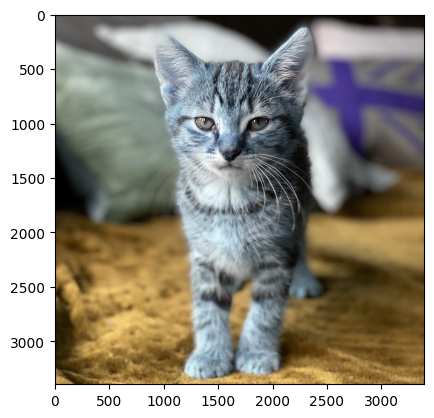

In [63]:
plt.imshow(bgr);

`plt.imshow` first examines the input argument (`bgr` in our case), and if it's an `ndarray` with shape `(height, width, 3)`, then it will render it as an RGB image, meaning it will expect that `bgr[:, :, 0]` is the red channel, but this is not the case when read using `cv.imread` function. This is the reason that the color channels are in reversed order in the picture above.

In order to correct this, we will reverse the channels after we read the image using numpy indexing `[..., ::-1]`.

In [64]:
rgb_cv = cv.imread('../data/fruits.jpg')[..., ::-1]
type(rgb_cv), rgb_cv.shape, rgb_cv.dtype

(numpy.ndarray, (3396, 3396, 3), dtype('uint8'))

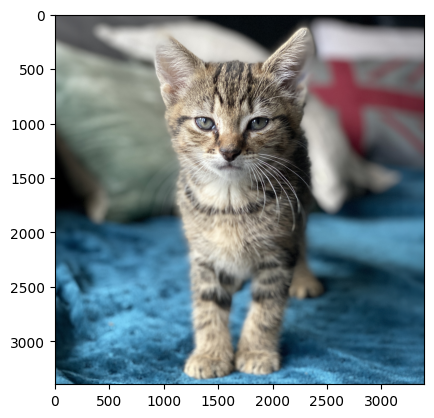

In [65]:
plt.imshow(rgb_cv);

In [66]:
np.abs(rgb - rgb_cv).sum()  # the same image as from skimage

0